# Um exemplo de predição de salários pelo site Glassdoor

### Notebook por [Danilo Gustavo Bispo]
#### [Glassdoor](http://www.glassdoor.com/)


## Conteúdo

1. [Introdução](#Introdução)

2. [Licença](#Licença)

3. [Bibliotecas utilizadas](#Bibliotecas-utilizadas)

4. [A problematização de negócio](#A-problematização-de-negócio)

5. [Coletando os dados](#Coletando-os-dados)

6. [Limpeza dos dados](#Limpeza-dos-dados)

7. [Análise exploratória](#Análise-exploratória)

8. [Criação do modelo](#Criação-do-modelo)

## Introdução

[[ voltar_ao topo ]](#Conteúdo)

Neste notebook será apresentado um pipeline básico de análise de dados no intuito de representar um típico workflow de projeto em ciência de dados.

Além de oferecer o código, a idéia é demonstrar um conjunto de boas práticas na tentativa de tornar o exemplo mais eficaz e colaborativo junto à comunidade de cientistas de dados. 

Será seguido o checklist do livro [The Elements of Data Analytic Style](https://leanpub.com/datastyle). Um guia rápido e gratuito para realização de análises de dados.

O artigo detalhando web-scraping do glassdoor [Artigo Scraper](https://towardsdatascience.com/selenium-tutorial-scraping-glassdoor-com-in-10-minutes-3d0915c6d905) junto com o [Github](https://github.com/arapfaik/scraping-glassdoor-selenium)

Outro artigo descrvendo a utlização do [Flask Productionization](https://towardsdatascience.com/productionize-a-machine-learning-model-with-flask-and-heroku-8201260503d2)

## Licença

[[ voltar ao topo ]](#Conteúdo)

No geral este material está disponibilizado para que seja utilizado e compartilhado de maneira plena.

## Bibliotecas utilizadas

[[ voltar ao topo ]](#Conteúdo)

Pode-se utilizar o pacote [Anaconda Python distribution](http://continuum.io/downloads) para instalar a maioria das bibliotecas e ferramentas necessárias.

Este notebook utiliza diversos pacotes que por padrão já vem com o Anaconda. As principais bibliotecas que serão utilizadas são:

* **numPy**: Fornece uma estrutura de arrays e matrizes multidimensionais com suas respectivas funções numéricas.
* **pandas**: Fornece estrutura dataframe para armazenar dados permitindo manipulação de maneira fácil e eficiente.
* **scikit-learn**: Pacote essencial de machine learning em Python.
* **matplotlib**: Biblioteca de visualizção de dados em Python.
* **seaborn**: Biblioteca avançada de ferramentas estatísticas.
* **watermark**: Extensão jupyter notebook para print de timestamps, versions, informações de hardware entre outros.
* **selenium**: API WebDriver utlizada para realizar a navegação entre páginas web
* **flask**: Flask é um pequeno framework web que provê um modelo simples para desenvolvimento web
* **pickle**: Utilizado para serializar e deserializar estrutura de objetos python.

**Nota:** Não será fornecido suporte para tentativas de executar este notebook sem a distribuição Anaconda.

## A problematização de negócio

[[ voltar ao topo ]](#Conteúdo)

O objetivo deste projeto consiste na criação de uma aplicação que sirva como ferramenta para estimar os salários no intuito de ajudar cientistas de dados negociar seus ganhos e benefícios quando conseguirem um emprego. Será construído um pipeline de análise de dados para o desenvolvimento desta aplicação.

Dentre as principais atividade estão as tarefas de realizar web-scraping sobre mais ou menos 1000 descrições de emprego da plataforma glassdoor. Elaborar features através do conteúdo extraído do texto de cada descrição de trabalho. Em seguida será criado um modelo de machine learning que utiliza as features recém criadas fim de identificar e predizer diferentes salários e benefícios baseados em tais medições.

O modelo será otimizado com Linear, Lasso and Random Forest Regresssors utilizando GridsearchCV para auxiliar na obtenção o melhor modelo. 

Finalmente o projeto encerra com a exposição de uma API permitindo acesso externo para realização de consultadas.

## Coletando os dados

[[ voltar ao topo ]](#Conteúdo)

Primeiramente vamos coletar as informações diretamente do site do glassdoor aplicando uma técnica de web scrapping com objetivo de realizar a extração dos dados.

Poderíamos utilizar a biblioteca do Glassdoor, porém ela fornece um número um tanto limitado de data points. Por exemplo não é permitido que se faça raspasgem de empregos ou avaliações. Você só consegue realizar extração de companhias. 

Portanto será utilizado uma técnica mais elaborada conforme o artigo [Selenium Tutorial: Scraping Glassdoor.com in 10 Minutes](https://towardsdatascience.com/selenium-tutorial-scraping-glassdoor-com-in-10-minutes-3d0915c6d905) implementado e compartilhado pelo cientista de dados Ömer Sakarya. 

O script abaixo foi adequado para atender as necessidades do glassdoor com vagas apenas do Brasil

In [ ]:
"""
author: Sakarya
url: https://github.com/arapfaik/scraping-glassdoor-selenium

"""
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium import webdriver
import time
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

def get_jobs(keyword, num_jobs, verbose, path, slp_time):
    
    #inicializando webdriver
    options = webdriver.ChromeOptions()
    
     
    #mudar o path quando o chromedriver estiver na pasta home
    driver = webdriver.Chrome(executable_path=path, options=options)
    driver.set_window_size(1120, 1000)
    
    url = "https://www.glassdoor.com/Job/jobs.htm?suggestCount=0&suggestChosen=false&clickSource=searchBtn&typedKeyword="+keyword+"&sc.keyword="+keyword+"&locT=&locId=&jobType="
    #url = 'https://www.glassdoor.com/Job/jobs.htm?sc.keyword="' + keyword + '"&locT=C&locId=1147401&locKeyword=San%20Francisco,%20CA&jobType=all&fromAge=-1&minSalary=0&includeNoSalaryJobs=true&radius=100&cityId=-1&minRating=0.0&industryId=-1&sgocId=-1&seniorityType=all&companyId=-1&employerSizes=0&applicationType=0&remoteWorkType=0'
    driver.get(url)
    jobs = []

        while len(jobs) < num_jobs:  

        #Sleep para aguardar a pagina carregar 
        time.sleep(slp_time)

        try:
            driver.find_element_by_class_name("selected").click()
        except ElementClickInterceptedException:
            pass

        time.sleep(.1)

        try:
            driver.find_element_by_css_selector('[alt="Close"]').click() #clicking to the X.
            print(' x out worked')
        except NoSuchElementException:
            print(' x out failed')
            pass

        
        #loop atraves de cada vaga de emprego encontrada 
        job_buttons = driver.find_elements_by_class_name("jl")  #.
        for job_button in job_buttons:  

            print("Progress: {}".format("" + str(len(jobs)) + "/" + str(num_jobs)))
            if len(jobs) >= num_jobs:
                break

            job_button.click()  
            time.sleep(1)
            collected_successfully = False
            
            while not collected_successfully:
                try:
                    nome_companhia = driver.find_element_by_xpath('.//div[@class="employerName"]').text
                    localizacao = driver.find_element_by_xpath('.//div[@class="location"]').text
                    titulo = driver.find_element_by_xpath('.//div[contains(@class, "title")]').text
                    descricao_vaga = driver.find_element_by_xpath('.//div[@class="jobDescriptionContent desc"]').text
                    collected_successfully = True
                except:
                    time.sleep(5)

            try:
                estimativa_salario = driver.find_element_by_xpath('.//span[@class="gray salary"]').text
            except NoSuchElementException:
                estimativa_salario = -1 
            
            try:
                avaliacao = driver.find_element_by_xpath('.//span[@class="rating"]').text
            except NoSuchElementException:
                rating = -1

            #Print para debug
            if verbose:
                print("Titulo do emprego: {}".format(titulo))
                print("Estimativa de salario: {}".format(estimativa_salario))
                print("Descricao da Vaga: {}".format(descricao_vaga[:500]))
                print("Avaliação: {}".format(avaliacao))
                print("Nome da Companhia: {}".format(nome_companhia))
                print("Localização: {}".format(localizacao))

            #Vai para a tab da empresa...
            #<div class="tab" data-tab-type="overview"><span>Company</span></div>
            try:
                driver.find_element_by_xpath('.//div[@class="tab" and @data-tab-type="overview"]').click()

                try:
                    tamanho = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Size"]//following-sibling::*').text
                except NoSuchElementException:
                    tamanho = -1

                try:
                    fundamento = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Founded"]//following-sibling::*').text
                except NoSuchElementException:
                    fundamento = -1

                try:
                    tipo_propriedade = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Type"]//following-sibling::*').text
                except NoSuchElementException:
                    tipo_propriedade = -1

                try:
                    industria = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Industry"]//following-sibling::*').text
                except NoSuchElementException:
                    industria = -1

                try:
                    setor = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Sector"]//following-sibling::*').text
                except NoSuchElementException:
                    setor = -1

                try:
                    receita = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Revenue"]//following-sibling::*').text
                except NoSuchElementException:
                    receita = -1

                try:
                    concorrencia = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Competitors"]//following-sibling::*').text
                except NoSuchElementException:
                    concorrencia = -1

            except NoSuchElementException:  #Raramente alguma vaga não cadastra os dados na tab companhia
                tamanho = -1
                fundamento = -1
                tipo_propriedade = -1
                industria = -1
                setor = -1
                receita = -1
                concorrencia = -1

                
            if verbose:
                print("Tamanho: {}".format(tamanho))
                print("Fundação: {}".format(fundamento))
                print("Tipo de propriedade: {}".format(tipo_propriedade))
                print("Industria: {}".format(industria))
                print("Setor: {}".format(setor))
                print("Receita: {}".format(receita))
                print("Concorrencia: {}".format(concorrencia))
                print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

            jobs.append({"Titulo" : titulo,
            "Estimativa_Salarial" : estimativa_salario,
            "Descricao_Vaga" : descricao_vaga,
            "Avaliacao" : avaliacao,
            "Nome_Companhia" : nome_companhia,
            "Localizacao" : localizacao,
            "Headquarters" : headquarters,
            "Tamanho" : tamanho,
            "Fundamento" : fundamento,
            "Tipo_Propriedade" : tipo_propriedade,
            "Industria" : industria,
            "Setor" : setor,
            "Receita" : receita,
            "Concorrencia" : concorrencia})

            
            
        #Simulando o clique do botão"proxima pagina"
        try:
            driver.find_element_by_xpath('.//li[@class="next"]//a').click()
        except NoSuchElementException:
            print("Scraping terminado antes de alcancar o numero de empregos estimado. Necessario {}, obteve {}.".format(num_jobs, len(jobs)))
            break

    return pd.DataFrame(jobs)  # Esta linha converte o objeto dicionario em um pandas DataFrame.

In [ ]:
#Ferramenta para testes automatizados de aplicativos da web em muitos navegadores
#https://chromedriver.chromium.org/
pathchromedriver = "/Users/danilogustavo/PythonFundmentals/Portfolio/EstimadorSalarioGlassdoor/chromedriver"

df = get_jobs('cientista de dados', 1000, False, pathchromedriver, 15)

df.to_csv('glassdoor_jobs.csv', index = False)

## Limpeza dos dados

[[ voltar ao topo ]](#Conteúdo)

O próximo passo consiste em lançar uma visão sobre os dados com os quais se pretende trabalhar. Considerando que por mais acurado aparentemente os dados possam se apresentar, erros podem estar contidos, portanto torna-se importante pontuar os erros antes de iniciar o processo de análise.

Por exemplo, as considerações servem para responder as seguintes questões:

* Existe algo de errado com os dados?
* Existe alguma peculiaridade com os dados?
* Será preciso corrigir ou remover algo relacionado aos dados?
* Será preciso acrescentar mais features para auxiliar na construção do modelo?

In [1]:
df = pd.read_csv('glassdoor_jobs.csv')

#parsing salario
df['Valor_hora'] = df['Estimativa_Salarial'].apply(lambda x: 1 if 'por_hora' in x.lower() else 0)
df['Salario_empregrador'] = df['Estimativa_Salarial'].apply(lambda x: 1 if 'salario_pelo_empregrador:' in x.lower() else 0)

df = df[df['Estimativa_Salarial'] != '-1']
salary = df['Estimativa_Salarial'].apply(lambda x: x.split('(')[0])
minus_Kd = salary.apply(lambda x: x.replace('K','').replace('$',''))

min_hr = minus_Kd.apply(lambda x: x.lower().replace('por_hora','').replace('salario_pelo_empregrador:',''))

df['min_salario'] = min_hr.apply(lambda x: int(x.split('-')[0]))
df['max_salario'] = min_hr.apply(lambda x: int(x.split('-')[1]))
df['avg_salario'] = (df.min_salary+df.max_salary)/2

#Campo nome companhia apenas com texto
df['Companhia_txt'] = df.apply(lambda x: x['Nome_Companhia'] if x['Avaliacao'] <0 else x['Nome_Companhia'][:-3], axis = 1)

#Incluindo campo estado
df['UF'] = df['Localizacao'].apply(lambda x: x.split(',')[1])
df.job_state.value_counts()

#Idade da empresa
df['Idade_companhia'] = df.Fundamento=.apply(lambda x: x if x <1 else 2020 - x)


#parsing da descricao da vaga (python, etc.)

#python
df['python_yn'] = df['Descricao_Vaga'].apply(lambda x: 1 if 'python' in x.lower() else 0)
 
#r studio 
df['R_yn'] = df['Descricao_Vaga'].apply(lambda x: 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() else 0)
df.R_yn.value_counts()

#spark 
df['spark'] = df['Descricao_Vaga'].apply(lambda x: 1 if 'spark' in x.lower() else 0)
df.spark.value_counts()

#aws 
df['aws'] = df['Descricao_Vaga'].apply(lambda x: 1 if 'aws' in x.lower() else 0)
df.aws.value_counts()

#excel
df['excel'] = df['Descricao_Vaga'].apply(lambda x: 1 if 'excel' in x.lower() else 0)
df.excel.value_counts()

df.columns

df_out = df.drop(['Unnamed: 0'], axis =1)

df_out.to_csv('glassdoor_jobs.csv',index = False)


In [39]:
df = pd.read_csv('glassdoor_jobs.csv')

Cada linha após o cabeçalho representa uma entrada com as fetures que serão utilizadas no modelo de predição.

Primeiramente vale realizar alguns ajustes nos campos relacionados aos títulos e perfis.

In [5]:
def titulo_simples(titulo):
    if 'cientista de dados' in titulo.lower():
        return 'cientista de dados'
    elif 'engenheiro de dados' in titulo.lower():
        return 'engenheiro de dados'
    if 'data scientist' in titulo.lower():
        return 'data scientist'
    elif 'data engineer' in titulo.lower():
        return 'data engineer'
    elif 'analista' in titulo.lower():
        return 'analista'
    elif 'machine learning' in titulo.lower():
        return 'mle'
    elif 'gerente' in titulo.lower():
        return 'gerente'
    elif 'diretor' in titulo.lower():
        return 'diretor'
    else:
        return 'na'
    
def senioridade(titulo):
    if 'sr' in titulo.lower() or 'senior' in titulo.lower() or 'sr' in titulo.lower() or 'lider' in titulo.lower() or 'principal' in titulo.lower():
            return 'senior'
    elif 'jr' in titulo.lower() or 'jr.' in titulo.lower():
        return 'jr'
    else:
        return 'na'

In [40]:
df['Titulo_simples'] = df['Titulo'].apply(titulo_simples)

In [ ]:
df.Titulo_simples.value_counts()

In [ ]:
df['Senioridade'] = df['Titulo'].apply(senioridade)

In [44]:
df['desc_len'] = df['Descricao_Vaga'].apply(lambda x: len(x))
df['desc_len']

0      2536
1      4783
2      3461
3      3883
4      2728
       ... 
737    6162
738    6130
739    3078
740    1642
741    3673
Name: desc_len, Length: 742, dtype: int64

In [45]:
#Contagem de concorrencia
df['Num_concorrencia'] = df['Concorrencia'].apply(lambda x: len(x.split(',')) if x != '-1' else 0)

In [47]:
#salario anual por hora 

df['min_salario'] = df.apply(lambda x: x.min_salary*2 if x.hourly ==1 else x.min_salary, axis =1)
df['max_salario'] = df.apply(lambda x: x.max_salary*2 if x.hourly ==1 else x.max_salary, axis =1)

In [51]:
df['Companhia_txt'] = df.company_txt.apply(lambda x: x.replace('\n', ''))

In [ ]:
df[df.hourly ==1][['valor_hora','min_salario','max_salario']]

In [ ]:
df.describe()

## Análise exploratória

[[ voltar ao topo ]](#Conteúdo)


A análise exploratória é a etapa em que podemos começar a nos aprofundar no conjunto de dados, além dos erros e discrepâncias. Procuraremos responder a perguntas como:

* Como os dados estão distribuídos?

* Existem correlações nos dados?

* Existem fatores de confusão que explicam essas correlações?


Este é o estágio em que plotamos todos os dados, mas não se preocupando com o visual, pois esses gráficos são para uso técnico analítico.

Agora vamos criar um **histograma** de algumas features. Ao explorar um conjunto de dados, muitas vezes é desejável entender rapidamente a distribuição de determinadas variáveis. Uma maneira comum de visualizar a distribuição de uma única variável numérica é utilizando histogramas. 

Um histograma divide os valores dentro de uma variável numérica em “bins” pelo o número de observações que caem em cada posição. 

Ao visualizar essas contagens de maneira colunar, podemos obter um senso bem imediato e intuitivo da distribuição dos valores dentro de uma variável.

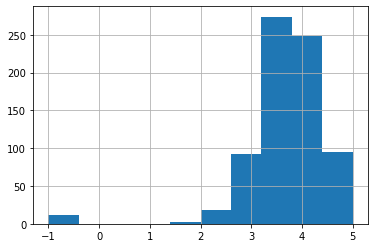

In [57]:
df.Avaliacao.hist()

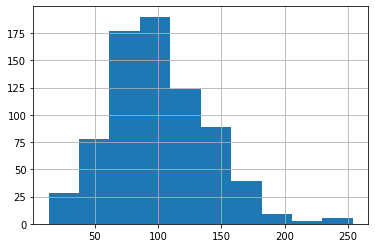

In [58]:
df.Estimativa_Salarial.hist()

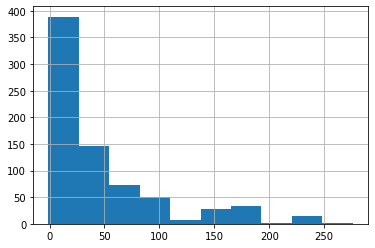

In [59]:
df.Idade_companhia.hist()

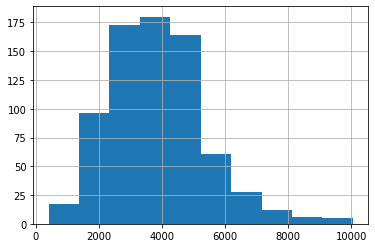

In [60]:
df.Desc_len.hist()

Vale plotar alguns boxplots para identifição de valores discrepantes e outliers dos dados, fornecendo assim um meio complementar para desenvolver uma perspectiva sobre o caráter dos dados. Além disso, serviondo também como uma disposição gráfica comparativa. 

O Boxplot captura o resumo dos dados de forma eficiente com uma simples caixa nos permitindo comparar facilmente entre grupos de informação. Basicamente um boxplot é uma maneira rápida de visualiar a forma de uma distribuição.

In [ ]:
df.boxplot(column = ['Idade_companhia','Estimativa_Salarial','Avaliacao'])

In [ ]:
df.boxplot(column = 'Avaliacao')

In [ ]:
df[['Idade_companhia','Estimativa_Salarial','Avaliacao','Desc_len']].corr()

Vale criar um mapa de calor para identificar possíveis correlações entre as features de idade, média salarial, avaliação, entre outros.

O mapa de calor é uma maneira de representar os dados em uma forma bidimensional. Os valores dos dados são representados como cores no gráfico. O objetivo do mapa de calor é fornecer um resumo visual colorido das informações.

In [ ]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df[['Idade_companhia','Estimativa_Salarial','Avaliacao','Desc_len','Num_concorrencia']].corr(),vmax=.3, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Criação de algumas visualizações por agrupamento

In [ ]:
pd.pivot_table(df, index = 'Titulo_simples', values = 'Estimativa_Salarial')

In [ ]:
pd.pivot_table(df, index = ['Titulo_simples','Senioridade'], values = 'Estimativa_Salarial')

In [ ]:
pd.pivot_table(df, index = ['Estado','Titulo_simples'], values = 'Estimativa_Salarial').sort_values('Estado', ascending = False)

In [90]:
pd.options.display.max_rows
pd.set_option('display.max_rows', None)

60

In [ ]:
pd.pivot_table(df, index = ['Estado','Titulo_simples'], values = 'Estimativa_Salarial', aggfunc = 'count').sort_values('Estado', ascending = False)

In [ ]:
pd.pivot_table(df[df.Titulo_simples == 'data scientist'], index = 'Estado', values = 'Estimativa_Salarial').sort_values('avg_salary', ascending = False)

In [110]:
df_pivots = df[['Avaliacao', 'Industria', 'Setor', 'Receita', 'Salario_empregrador', 'python_yn', 'R_yn', 'spark', 'aws', 'excel', 'Tipo_Propriedade','Estimativa_Salarial']]

In [ ]:
df_pivots = df[['Avaliacao', 'Industria', 'Setor', 'Receita', 'Salario_empregrador', 'python_yn', 'R_yn', 'spark', 'aws', 'excel', 'Tipo_Propriedade','Estimativa_Salarial']]

In [ ]:
pd.pivot_table(df_pivots, index = 'Receita', columns = 'python_yn', values = 'Estimativa_Salarial', aggfunc = 'count')

In [124]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Algortmo simples para exibição de nuvem de palavras destacando aquelas que estiverem maior relevância

In [ ]:
words = " ".join(df['Descricao_Vaga'])

def punctuation_stop(text):
    """remocao de pontuacao"""
    filtered = []
    stop_words = set(stopwords.words('portugues'))
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered


words_filtered = punctuation_stop(words)

text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=1,stopwords=STOPWORDS, max_words = 2000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show()

## Criação do modelo

[[ voltar ao topo ]](#Conteúdo)


Organizar e explorar os dados é um componente vital para a análise de dados. Caso tivesse sido pulado e partido diretamente para a etapa de modelagem, existiriam grandes chances de contruírmos um modelo de classificação com sérios problemas.


<hr />

Após assegurar que os dados estejam limpos e embuído com algum conhecimento - mesmo que superficial sobre suas distribuições e relacionamentos, chegou o momento de dar o próximo passo na análise dividindo os dados nos sets de treinamento e teste.

Um **set de treinamento** é um subconjunto aleatório de dados utilizado para o treinamento dos modelos. Um **set de teste** é um subconjunto aleatório de dados (mutuamente exclusivo dos dados de treino) utilizado para validar os modelos e prepará-los para entradas futuras e imprevistas.

Especialmente em dados esparsos, aumenta-se a chance dos modelos sofrerem com sobreajuste **overfit**. O modelo aprenderá tão bem sobre o conjunto de treinamento, que por sua vez, não será capaz de lidar em sua grande maioria com os dados de casos nunca vistos em validações anteriores. Portanto é importante que seja construído o modelo com dados de treinamento para somente então validá-lo com o conjunto de testes posteriormente.

In [ ]:
# escolha de colunas relevantes
df.columns

df_model = df[['Estimativa_Salarial','Avaliacao','Tamanho','Tipo_propriedade','Industria','Setor','Receita','Num_concorrencia','Valor_hora','Salario_empregrador',
             'Estado','Mesmo_estado','Idade','python_yn','spark','aws','excel','Titulo_simples','Senioridade','Desc_len']]

# dados dummy
df_dum = pd.get_dummies(df_model)


from sklearn.model_selection import train_test_split

X = df_dum.drop('Estimativa_Salarial', axis =1)
y = df_dum.Estimativa_Salarial.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# regressao linear multipla
import statsmodels.api as sm

X_sm = X = sm.add_constant(X)
model = sm.OLS(y,X_sm)
model.fit().summary()

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
lm.fit(X_train, y_train)

np.mean(cross_val_score(lm,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

# regressao lasso 
lm_l = Lasso(alpha=.13)
lm_l.fit(X_train,y_train)
np.mean(cross_val_score(lm_l,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

alpha = []
error = []

for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lml,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3)))
    
plt.plot(alpha,error)

err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns = ['alpha','error'])
df_err[df_err.error == max(df_err.error)]

# random forest 
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

np.mean(cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 3))

# tune GridsearchCV 
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':range(10,300,10), 'criterion':('mse','mae'), 'max_features':('auto','sqrt','log2')}

gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=3)
gs.fit(X_train,y_train)

gs.best_score_
gs.best_estimator_

# teste de ensembles 
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,tpred_lm)
mean_absolute_error(y_test,tpred_lml)
mean_absolute_error(y_test,tpred_rf)

mean_absolute_error(y_test,(tpred_lm+tpred_rf)/2)

import pickle
pickl = {'model': gs.best_estimator_}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )

file_name = "model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

model.predict(np.array(list(X_test.iloc[1,:])).reshape(1,-1))[0]

list(X_test.iloc[1,:])